# IMPORTACIÓN DE MÓDULOS, PERMISOS Y ARCHIVOS

In [ ]:
# bloque de siempre de los ejemplos de la materia
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

In [ ]:
# DEL TUTORIAL RICHTERS
# USAN RANDOM FOREST CLASSIFIER, GRIDSEARCHCV Y LA METRICA F1_SCORE
# (https://www.drivendata.co/blog/richters-predictor-benchmark/)

# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

# DE LA PRACTICA DE RANDOM FOREST DE LA LISTA DE ARBOLES
# USAN RANDOM FOREST REGRESSOR Y LA METRICA MEAN_SCUARED_ERROR
# (https://www.youtube.com/watch?v=kEmCq_OZo5k&list=PLeo_qKwGPZYeJQb-M1nE_cnj43uOKZtf2&index=5)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split  #UTILIZADO PARA EL SPLIT EN TRAIN Y TEST
from sklearn.metrics import confusion_matrix, accuracy_score

# para utilizar xgboost
import xgboost as xgb


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Datos en https://www.drivendata.org/competitions/57/nepal-earthquake/data/

#train_labels
id='1Ya1IBEEN9_e27K9D9m5eM156XSO-GlPk'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_labels.csv')
train_labels = pd.read_csv('train_labels.csv',index_col='building_id')

#train_values
id='1RrkY3TWaaQUQf_FuXyNO-l6A4v7Zut_1'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
train_values = pd.read_csv('train_values.csv',index_col='building_id')

#test_values
id='1jNEjI4_U4Z59d0SLHdikjgXABj_ECDY9'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values.csv')
test_values = pd.read_csv('test_values.csv',index_col='building_id')

#submission_format
id='1tElv0_dqkiT-U7-UFqpLIfFlpi_7MBdm'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('submission_format.csv')
submission_format = pd.read_csv('submission_format.csv',index_col='building_id')

In [ ]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

In [ ]:
train_values.shape

(260601, 38)

In [ ]:
train_labels.shape

(260601, 1)

# FILTRADO DE OUTLIERS DEL TP1

FILTRADO DE OUTLIERS DEL TP1

In [ ]:
# generamos una copia de train_values en earthquakes
# filtramos los outliers encontrados en el análisis exploratorio del tp1
# los datos de height_percentage=32 (alto, para pocos pisos, con damage3)
# en el geolevel1=17 corresponden al geolevel2=721
# a su vez filtramos los datos de antigüedad mayor a 900 años

earthquakes=train_values

filtro_geolevel1=earthquakes['geo_level_1_id']==17
filtro_geolevel2=earthquakes['geo_level_2_id']==721
filtro_height=earthquakes['height_percentage']==32
filtro_age=earthquakes['age']>900

earthquakes_no=earthquakes[filtro_geolevel1]
earthquakes_no=earthquakes[filtro_geolevel2]
earthquakes_no=earthquakes[filtro_height]
earthquakes_no=earthquakes[filtro_age]
earthquakes_no.reset_index(inplace=True)

# para completar el filtrado realizamos un leftjoin del df filtrado
# con el indicator que nos permitirá elegir solo los datos left_only
# para este paso se quita y vuelve a setear el building_id como index

earthquakes=earthquakes.merge(earthquakes_no['building_id'],how='left', on='building_id',indicator='True')

earthquakes=earthquakes[earthquakes['True']=='left_only']
earthquakes.set_index('building_id',inplace=True)

In [ ]:
# generamos earthquakes_labels y filtramos también los outliers del mismo

earthquakes_labels=train_labels

earthquakes_labels=earthquakes_labels.merge(earthquakes_no['building_id'],how='left', on='building_id',indicator='True')
earthquakes_labels=earthquakes_labels[earthquakes_labels['True']=='left_only'].loc[:,['building_id','damage_grade']]
earthquakes_labels.set_index('building_id',inplace=True)

# INCORPORACION DE NUEVAS FEATURES

INCORPORACION DE NUEVAS FEATURES POR RATIOS Y ENCODING

In [ ]:
# dado que geolevel_1_id es una variable que a nuestro entender
# representa la ubicación geográfica regional de los datos (p.e. provincia)
# y dado que la misma es numérica con datos del 0 al 30 pero su orden numérico no tiene relación util
# generamos un dict con los 5 bit correspondientes a cada valor de geolevel para hacer un binaryencoding
# al ser solo 31 valores los posibles de geo_level_1_id, alcanzan 5 bits (log2 32 = 5)

binarios_geo1={'geo_level_1_id':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
               'geolevel1_bit1':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
               'geolevel1_bit2':[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],
               'geolevel1_bit3':[0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1],
               'geolevel1_bit4':[0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1],
               'geolevel1_bit5':[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]}

# realizamos un join de los valores del diccionario como dataframe y los valores con su index de geo_level_1_id
df_bits=earthquakes.loc[:,['geo_level_1_id']].join(pd.DataFrame.from_dict(binarios_geo1),on='geo_level_1_id',lsuffix='bin')

# luego creamos un df llamado earthquakes_ampliado a partir de un
# join del dataframe anterior al resto del subset de entrenamiento
earthquakes_ampliado=earthquakes.join(df_bits.loc[:,['geolevel1_bit1','geolevel1_bit2','geolevel1_bit3','geolevel1_bit4','geolevel1_bit5']])

In [ ]:
# incorporamos el campo ratio edificio (sale del análisis exploratorio realizado en el tp1)
earthquakes_ampliado['ratio_edificio']=earthquakes_ampliado['height_percentage']/earthquakes_ampliado['area_percentage']

# incorporamos el campo volumen edificio
earthquakes_ampliado['volumen_edificio']=earthquakes_ampliado['height_percentage']*earthquakes_ampliado['area_percentage']

# incorporamos el campo volumen piso
earthquakes_ampliado['volumen_piso']=(earthquakes_ampliado['height_percentage']*earthquakes_ampliado['area_percentage'])/earthquakes_ampliado['count_floors_pre_eq']

# incorporamos el campo indice_edificio
earthquakes_ampliado['indice_edificio']=earthquakes_ampliado['age']/(earthquakes_ampliado['height_percentage']*earthquakes_ampliado['area_percentage'])/earthquakes_ampliado['count_floors_pre_eq']

# incorporamos el campo indice_edificio10
earthquakes_ampliado['indice_edificio']=(earthquakes_ampliado['age']/(earthquakes_ampliado['height_percentage']*earthquakes_ampliado['area_percentage'])/earthquakes_ampliado['count_floors_pre_eq'])*10



In [ ]:
# incorporamos tambien para pruebas una media de cantidad de pisos para geo_level_1_id
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_1_id','count_floors_pre_eq']].groupby('geo_level_1_id').mean(),on='geo_level_1_id',rsuffix='_geo1mean')

# incorporamos campos con un mean de age/height_percentage/area_percentage/count_floors_pre_eq
# para cada geo_level_2_id
# de esta manera podemos utilizarlo ya que tiene 1400 datos aprox
# de ubicación subregional, en una variable numérica sin orden alguno
# sería una manera de representar las 1400 regiones
# por sus medias de antigüedad, area y altura de las construcciones en ellas

earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_2_id','age']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_2_id','area_percentage']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_2_id','height_percentage']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_2_id','count_floors_pre_eq']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')

# incorporamos campos con un mean de age/height_percentage/area_percentage/count_floors_pre_eq
# para cada geo_level_3_id
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_3_id','age']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_3_id','area_percentage']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_3_id','height_percentage']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado=earthquakes_ampliado.join(earthquakes_ampliado.loc[:,['geo_level_3_id','count_floors_pre_eq']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')

# generamos ratio_edificio de geo3
earthquakes_ampliado['ratio_edificio_geo3']=earthquakes_ampliado['height_percentage_geo3mean']/earthquakes_ampliado['area_percentage_geo3mean']

earthquakes_ampliado

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,True,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,0,1,1,0,0.83,30,15.00,5.00,2.22,22.20,7.49,5.22,1.95,23.38,7.43,4.81,1.92,0.65
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,0,0,0.88,56,28.00,0.89,2.21,17.31,6.65,5.64,2.17,13.75,8.81,7.25,2.25,0.82
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,0,1,1.00,25,12.50,2.00,2.53,20.41,8.59,6.49,2.71,30.85,9.81,6.55,2.65,0.67
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,1,0,0.83,30,15.00,1.67,1.85,18.39,5.87,3.74,1.55,17.26,8.23,4.87,1.94,0.59
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,1,1,1.12,72,24.00,1.39,2.55,35.07,8.83,6.10,2.33,30.20,8.45,6.98,2.17,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,1,0,0,1,0.50,18,18.00,30.56,1.80,26.16,7.20,2.97,1.00,26.79,10.79,3.00,1.00,0.28
669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,0.83,30,15.00,0.00,2.32,19.21,8.20,5.92,2.67,16.73,8.12,6.51,2.76,0.80
602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,1.17,42,14.00,4.37,2.32,21.02,5.38,6.62,2.77,28.18,6.14,6.50,2.77,1.06


In [ ]:
# hacemos un mean encoding a partir de los materiales constructivos

# para esto primero buscamos el promedio de las variables numericas, para la aparicion de cada material en el set de datos
materials=[]
materials_A=earthquakes_ampliado.groupby('has_superstructure_adobe_mud').mean()
materials_B=earthquakes_ampliado.groupby('has_superstructure_mud_mortar_stone').mean()
materials_C=earthquakes_ampliado.groupby('has_superstructure_stone_flag').mean()
materials_D=earthquakes_ampliado.groupby('has_superstructure_cement_mortar_stone').mean()
materials_E=earthquakes_ampliado.groupby('has_superstructure_mud_mortar_brick').mean()
materials_F=earthquakes_ampliado.groupby('has_superstructure_cement_mortar_brick').mean()
materials_G=earthquakes_ampliado.groupby('has_superstructure_timber').mean()
materials_H=earthquakes_ampliado.groupby('has_superstructure_bamboo').mean()
materials_I=earthquakes_ampliado.groupby('has_superstructure_rc_non_engineered').mean()
materials_J=earthquakes_ampliado.groupby('has_superstructure_rc_engineered').mean()
materials_K=earthquakes_ampliado.groupby('has_superstructure_other').mean()

materials_A=materials_A.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_A['material']='A'
materials=materials_A
materials_B=materials_B.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_B['material']='B'
materials_C=materials_C.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_C['material']='C'
materials_D=materials_D.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_D['material']='D'
materials_E=materials_E.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_E['material']='E'
materials_F=materials_F.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_F['material']='F'
materials_G=materials_G.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_G['material']='G'
materials_H=materials_H.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_H['material']='H'
materials_I=materials_I.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_I['material']='I'
materials_J=materials_J.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_J['material']='J'
materials_K=materials_K.loc[:,['age','area_percentage','height_percentage','count_floors_pre_eq','count_families']].filter(like='1',axis=0)
materials_K['material']='K'

materials=materials.append(materials_B,ignore_index=True)
materials=materials.append(materials_C,ignore_index=True)
materials=materials.append(materials_D,ignore_index=True)
materials=materials.append(materials_E,ignore_index=True)
materials=materials.append(materials_F,ignore_index=True)
materials=materials.append(materials_G,ignore_index=True)
materials=materials.append(materials_H,ignore_index=True)
materials=materials.append(materials_I,ignore_index=True)
materials=materials.append(materials_J,ignore_index=True)
materials=materials.append(materials_K,ignore_index=True)

materials
# nos quedará una tabla donde por cada material de construccion, reetiquetado de la A a la K
# tenemos un promedio de edad, area, altura, pisos, y familias

,age,area_percentage,height_percentage,count_floors_pre_eq,count_families,material
0,34.52,8.38,6.35,2.54,1.03,A
1,21.51,7.46,5.32,2.12,0.98,B
2,22.71,8.01,5.23,1.97,0.99,C
3,15.45,10.40,5.62,2.07,0.96,D
4,41.08,8.89,6.91,2.82,1.03,E
5,12.94,11.25,5.44,1.91,0.96,F
6,20.22,7.61,5.26,2.06,0.98,G
7,18.16,7.56,5.04,1.96,0.98,H
8,13.69,11.88,6.22,2.15,0.96,I
9,6.95,15.77,7.40,2.41,0.94,J


In [ ]:
# creamos una funcion para calcular promedios de materiales de construccion para cada registro

def calcular_meanmaterial(df,df_means):
  newCol1=[]
  newCol2=[]
  newCol3=[]
  newCol4=[]
  newCol5=[]
  for index,row in df.iterrows():
    meanValue_age = 0.0
    meanValue_area_percentage	= 0.0
    meanValue_height_percentage = 0.0
    meanValue_count_floors_pre_eq = 0.0
    meanValue_count_families = 0.0
    contador=0
    if (row['has_superstructure_adobe_mud'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='A']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='A']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='A']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='A']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='A']['count_families'].values[0]
    if (row['has_superstructure_mud_mortar_stone'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='B']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='B']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='B']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='B']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='B']['count_families'].values[0]

    if (row['has_superstructure_stone_flag'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='C']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='C']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='C']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='C']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='C']['count_families'].values[0]


    if (row['has_superstructure_cement_mortar_stone'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='D']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='D']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='D']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='D']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='D']['count_families'].values[0]


    if (row['has_superstructure_mud_mortar_brick'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='E']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='E']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='E']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='E']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='E']['count_families'].values[0]


    if (row['has_superstructure_cement_mortar_brick'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='F']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='F']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='F']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='F']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='F']['count_families'].values[0]


    if (row['has_superstructure_timber'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='G']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='G']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='G']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='G']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='G']['count_families'].values[0]


    if (row['has_superstructure_bamboo'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='H']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='H']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='H']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='H']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='H']['count_families'].values[0]


    if (row['has_superstructure_rc_non_engineered'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='I']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='I']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='I']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='I']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='I']['count_families'].values[0]


    if (row['has_superstructure_rc_engineered'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='J']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='J']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='J']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='J']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='J']['count_families'].values[0]


    if (row['has_superstructure_other'] == 1):
      contador += 1
      meanValue_age += df_means.loc[df_means['material']=='K']['age'].values[0]
      meanValue_area_percentage += df_means.loc[df_means['material']=='K']['area_percentage'].values[0]
      meanValue_height_percentage += df_means[df_means['material']=='K']['height_percentage'].values[0]
      meanValue_count_floors_pre_eq += df_means[df_means['material']=='K']['count_floors_pre_eq'].values[0]
      meanValue_count_families += df_means[df_means['material']=='K']['count_families'].values[0]

    newCol1.append(meanValue_age/contador)
    newCol2.append(meanValue_area_percentage/contador)
    newCol3.append(meanValue_height_percentage/contador)
    newCol4.append(meanValue_count_floors_pre_eq/contador)
    newCol5.append(meanValue_count_families/contador)
    
  return newCol1,newCol2,newCol3,newCol4,newCol5

materials_mean =  calcular_meanmaterial(earthquakes_ampliado.iloc[:,:],materials)

In [ ]:
earthquakes_ampliado['materialsmean_age']=materials_mean[0]
earthquakes_ampliado['materialsmean_area_percentage']=materials_mean[1]
earthquakes_ampliado['materialsmean_height_percentage']=materials_mean[2]
earthquakes_ampliado['materialsmean_count_floors_pre_eq']=materials_mean[3]
earthquakes_ampliado['materialsmean_count_families']=materials_mean[4]

earthquakes_ampliado['material_indice']=earthquakes_ampliado['materialsmean_age']/(earthquakes_ampliado['materialsmean_area_percentage']*earthquakes_ampliado['materialsmean_height_percentage'])/earthquakes_ampliado['materialsmean_count_floors_pre_eq']
earthquakes_ampliado

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,True,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice,materials,secondary_use,construction_type
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,0,1,1,0,0.83,30,15.00,5.00,2.22,22.20,7.49,5.22,1.95,23.38,7.43,4.81,1.92,0.65,28.01,7.92,5.84,2.33,1.01,0.26,0.58,F,0.00
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,0,0,0.88,56,28.00,0.89,2.21,17.31,6.65,5.64,2.17,13.75,8.81,7.25,2.25,0.82,21.51,7.46,5.32,2.12,0.98,0.26,0.58,F,0.00
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,0,1,1.00,25,12.50,2.00,2.53,20.41,8.59,6.49,2.71,30.85,9.81,6.55,2.65,0.67,21.51,7.46,5.32,2.12,0.98,0.26,0.58,F,0.00
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,1,0,0.83,30,15.00,1.67,1.85,18.39,5.87,3.74,1.55,17.26,8.23,4.87,1.94,0.59,19.96,7.54,5.21,2.05,0.98,0.25,0.25,F,0.00
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,1,1,1.12,72,24.00,1.39,2.55,35.07,8.83,6.10,2.33,30.20,8.45,6.98,2.17,0.83,34.52,8.38,6.35,2.54,1.03,0.26,0.17,F,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,1,0,0,1,0.50,18,18.00,30.56,1.80,26.16,7.20,2.97,1.00,26.79,10.79,3.00,1.00,0.28,21.51,7.46,5.32,2.12,0.98,0.26,0.58,F,2.00
669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,0.83,30,15.00,0.00,2.32,19.21,8.20,5.92,2.67,16.73,8.12,6.51,2.76,0.80,21.51,7.46,5.32,2.12,0.98,0.26,0.58,F,0.00
602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,1.17,42,14.00,4.37,2.32,21.02,5.38,6.62,2.77,28.18,6.14,6.50,2.77,1.06,21.51,7.46,5.32,2.12,0.98,0.26,0.58,F,0.00


In [ ]:
# de la misma manera agregamos los correspondientes campos al set de test provisto
# mean encoding de area, height, age, count_floors por geolevel2 y geolevel3
# mean encoding de count_floors por geolevel1
# ratio_edificio (area vs altura) para todos los registros
# ratio_edificio a partir de los mean de geo3

earthquakes_test=test_values
df_bits_test=earthquakes_test.loc[:,['geo_level_1_id']].join(pd.DataFrame.from_dict(binarios_geo1),on='geo_level_1_id',lsuffix='bin')
earthquakes_ampliado_test=earthquakes_test.join(df_bits_test.loc[:,['geolevel1_bit1','geolevel1_bit2','geolevel1_bit3','geolevel1_bit4','geolevel1_bit5']])
earthquakes_ampliado_test['ratio_edificio']=earthquakes_ampliado_test['height_percentage']/earthquakes_ampliado_test['area_percentage']
earthquakes_ampliado_test['volumen_edificio']=earthquakes_ampliado_test['height_percentage']*earthquakes_ampliado_test['area_percentage']
earthquakes_ampliado_test['volumen_piso']=(earthquakes_ampliado_test['height_percentage']*earthquakes_ampliado_test['area_percentage'])/earthquakes_ampliado_test['count_floors_pre_eq']
earthquakes_ampliado_test['indice_edificio']=earthquakes_ampliado_test['age']/(earthquakes_ampliado_test['height_percentage']*earthquakes_ampliado_test['area_percentage'])/earthquakes_ampliado_test['count_floors_pre_eq']
earthquakes_ampliado_test['indice_edificio']=(earthquakes_ampliado_test['age']/(earthquakes_ampliado_test['height_percentage']*earthquakes_ampliado_test['area_percentage'])/earthquakes_ampliado_test['count_floors_pre_eq'])*10
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_1_id','count_floors_pre_eq']].groupby('geo_level_1_id').mean(),on='geo_level_1_id',rsuffix='_geo1mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_2_id','age']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_2_id','area_percentage']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_2_id','height_percentage']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_2_id','count_floors_pre_eq']].groupby('geo_level_2_id').mean(),on='geo_level_2_id',rsuffix='_geo2mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_3_id','age']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_3_id','area_percentage']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_3_id','height_percentage']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado_test=earthquakes_ampliado_test.join(earthquakes_ampliado_test.loc[:,['geo_level_3_id','count_floors_pre_eq']].groupby('geo_level_3_id').mean(),on='geo_level_3_id',rsuffix='_geo3mean')
earthquakes_ampliado_test['ratio_edificio_geo3']=earthquakes_ampliado_test['height_percentage_geo3mean']/earthquakes_ampliado_test['area_percentage_geo3mean']

earthquakes_ampliado_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.86,42,14.00,1.59,2.31,24.67,8.36,5.62,2.76,33.75,10.00,6.00,3.00,0.60
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.38,65,32.50,1.92,2.23,25.62,7.69,5.46,1.98,41.67,8.67,5.00,2.00,0.58
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.25,20,10.00,1.25,1.86,20.88,5.41,4.71,1.88,20.00,7.25,4.50,1.75,0.62
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0.16,57,57.00,0.00,1.69,21.84,15.61,4.69,1.52,11.97,20.52,6.11,1.88,0.30
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.88,56,18.67,0.89,2.31,25.48,8.02,5.98,2.48,22.14,7.43,6.14,2.57,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.30,120,40.00,1.94,2.14,22.60,9.31,5.27,2.46,47.00,17.50,6.00,2.50,0.34
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.17,42,14.00,1.98,2.05,24.43,6.23,5.06,2.17,24.29,6.00,6.14,2.57,1.02
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.00,9,9.00,55.56,1.86,21.97,8.44,4.38,1.89,33.75,8.50,5.00,2.00,0.59


In [ ]:
materials_mean_test =  calcular_meanmaterial(earthquakes_ampliado_test.iloc[:,:],materials)

In [ ]:
earthquakes_ampliado_test['materialsmean_age']=materials_mean_test[0]
earthquakes_ampliado_test['materialsmean_area_percentage']=materials_mean_test[1]
earthquakes_ampliado_test['materialsmean_height_percentage']=materials_mean_test[2]
earthquakes_ampliado_test['materialsmean_count_floors_pre_eq']=materials_mean_test[3]
earthquakes_ampliado_test['materialsmean_count_families']=materials_mean_test[4]

earthquakes_ampliado_test['material_indice']=earthquakes_ampliado_test['materialsmean_age']/(earthquakes_ampliado_test['materialsmean_area_percentage']*earthquakes_ampliado_test['materialsmean_height_percentage'])/earthquakes_ampliado_test['materialsmean_count_floors_pre_eq']
earthquakes_ampliado_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.86,42,14.00,1.59,2.31,24.67,8.36,5.62,2.76,33.75,10.00,6.00,3.00,0.60,21.51,7.46,5.32,2.12,0.98,0.26
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.38,65,32.50,1.92,2.23,25.62,7.69,5.46,1.98,41.67,8.67,5.00,2.00,0.58,21.51,7.46,5.32,2.12,0.98,0.26
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.25,20,10.00,1.25,1.86,20.88,5.41,4.71,1.88,20.00,7.25,4.50,1.75,0.62,21.51,7.46,5.32,2.12,0.98,0.26
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0.16,57,57.00,0.00,1.69,21.84,15.61,4.69,1.52,11.97,20.52,6.11,1.88,0.30,12.94,11.25,5.44,1.91,0.96,0.11
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.88,56,18.67,0.89,2.31,25.48,8.02,5.98,2.48,22.14,7.43,6.14,2.57,0.83,21.51,7.46,5.32,2.12,0.98,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.30,120,40.00,1.94,2.14,22.60,9.31,5.27,2.46,47.00,17.50,6.00,2.50,0.34,20.86,7.54,5.29,2.09,0.98,0.25
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.17,42,14.00,1.98,2.05,24.43,6.23,5.06,2.17,24.29,6.00,6.14,2.57,1.02,26.24,7.95,5.63,2.21,1.00,0.27
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.00,9,9.00,55.56,1.86,21.97,8.44,4.38,1.89,33.75,8.50,5.00,2.00,0.59,20.86,7.54,5.29,2.09,0.98,0.25


Text(0.5, 1.05, 'area_percentage_mean vs height_percentage_mean')

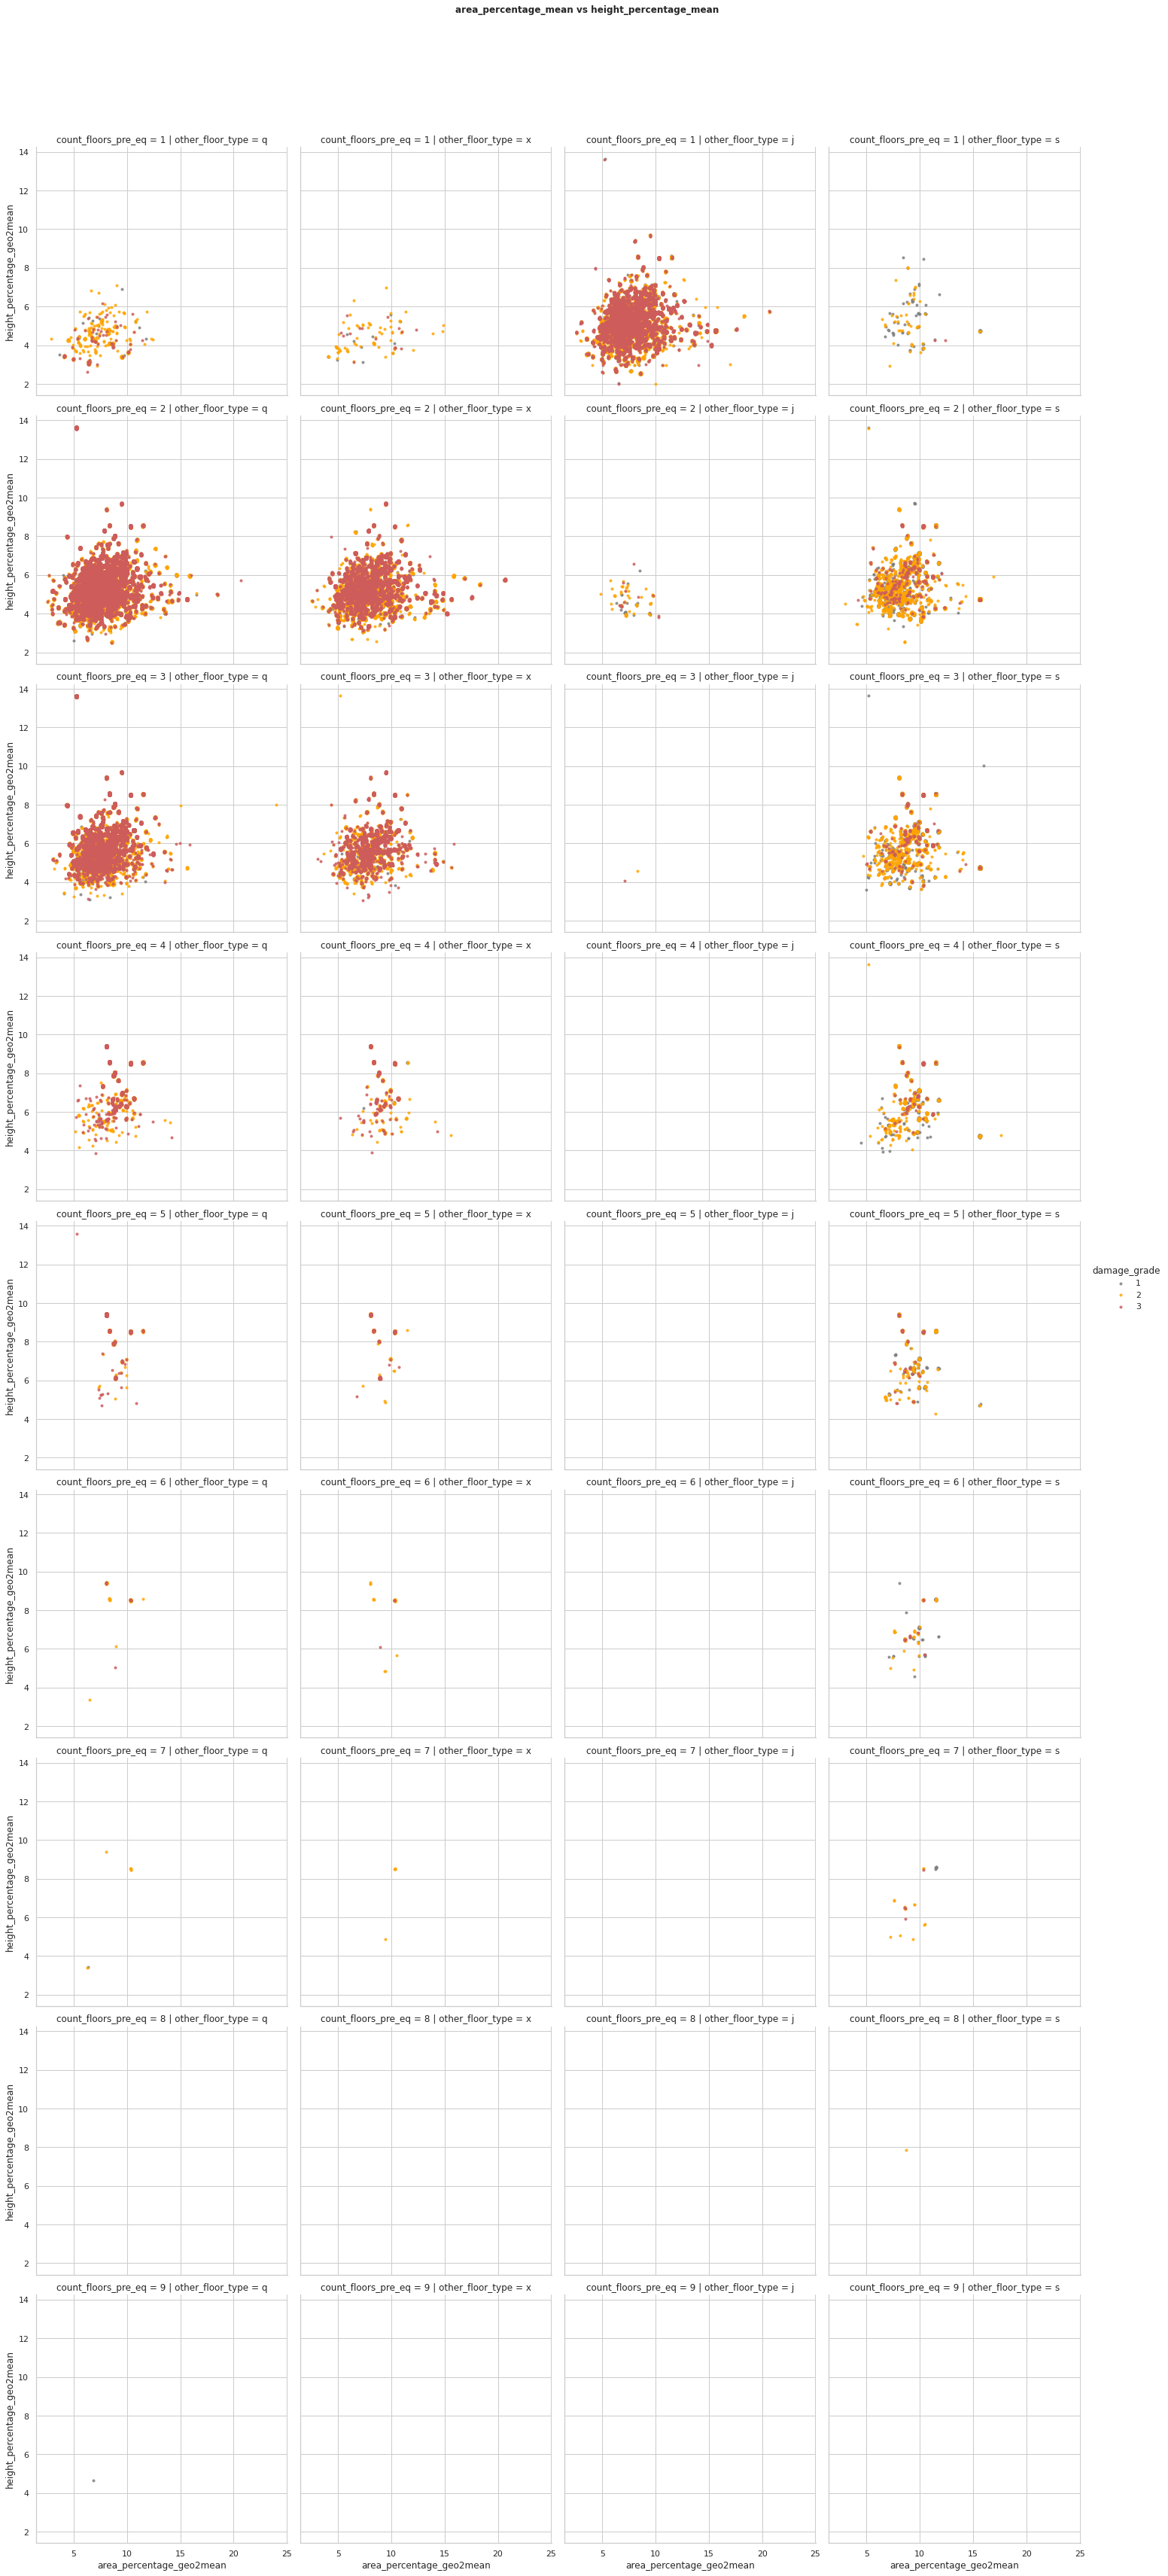

In [ ]:
# realizamos un análisis exploratorio en búsqueda de categorias divisoras de grado de daño en variables categóricas
# para lo cual se realiza una serie de gráficos de altura vs area promedio de cada geolevel2 incorporado como valor a cada registro
# la comparacion de la distribución de este ratio para cantidad de pisos, grado de daño y una variable categorica
# permite buscar categorias que generen una división del grado de daño, para ser utilizadas en algunos modelos

lm = sns.lmplot(data=earthquakes_ampliado.join(earthquakes_labels), y='height_percentage_geo2mean', x='area_percentage_geo2mean', markers='.'\
           ,y_jitter=0.05,x_jitter=0.05,fit_reg=False\
           ,row='count_floors_pre_eq',col='other_floor_type',hue='damage_grade',palette=['gray','orange','indianred'])#col_wrap=5,palette='RdYlBu_r')
fig = lm.fig 
fig.suptitle("area_percentage_mean vs height_percentage_mean", fontsize=12, fontweight='bold', y=1.05)

# Del analisis de graficos de ratios categorizados se ven 7 categorias divisoras de damage:

# foundation_type_i
# foundation_type_u
# ground_floor_type_v
# other_floor_type_s
# plan_configuration_u
# roof_type_x

# Preparación de Datos Adicional (para mean encoding)

In [ ]:
# CODIGO PARA MEAN ENCODING

def asignarCodigo(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if (row['has_superstructure_adobe_mud'] == 1):
      newValue += 'A'
    if (row['has_superstructure_mud_mortar_stone'] == 1):
      newValue += 'B'
    if (row['has_superstructure_stone_flag'] == 1):
      newValue += 'C'
    if (row['has_superstructure_cement_mortar_stone'] == 1):
      newValue += 'D'
    if (row['has_superstructure_mud_mortar_brick'] == 1):
      newValue += 'E'
    if (row['has_superstructure_cement_mortar_brick'] == 1):
      newValue += 'F'
    if (row['has_superstructure_timber'] == 1):
      newValue += 'G'
    if (row['has_superstructure_bamboo'] == 1):
      newValue += 'H'
    if (row['has_superstructure_rc_non_engineered'] == 1):
      newValue += 'I'
    if (row['has_superstructure_rc_engineered'] == 1):
      newValue += 'J'
    if (row['has_superstructure_other'] == 1):
      newValue += 'K'
    newColumn.append(newValue)
  return newColumn
       
#train
earthquakes_by_construction_material = earthquakes_ampliado
materials = asignarCodigo(earthquakes_by_construction_material)
#test
earthquakes_by_construction_material_test = earthquakes_ampliado_test
materials_test = asignarCodigo(earthquakes_by_construction_material_test)


In [ ]:
material_det = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone','has_superstructure_stone_flag','has_superstructure_cement_mortar_stone',
                'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick','has_superstructure_timber','has_superstructure_bamboo',
                'has_superstructure_rc_non_engineered','has_superstructure_rc_engineered','has_superstructure_other'] 
letras = ['A','B','C','D','E','F','G','H','I','J','K']

detalle = {'material': material_det, 'letra': letras}
detalle = pd.DataFrame(data=detalle)
detalle

,material,letra
0,has_superstructure_adobe_mud,A
1,has_superstructure_mud_mortar_stone,B
2,has_superstructure_stone_flag,C
3,has_superstructure_cement_mortar_stone,D
4,has_superstructure_mud_mortar_brick,E
5,has_superstructure_cement_mortar_brick,F
6,has_superstructure_timber,G
7,has_superstructure_bamboo,H
8,has_superstructure_rc_non_engineered,I
9,has_superstructure_rc_engineered,J


In [ ]:
#train
earthquakes_by_construction_material['materials'] = materials
#test
earthquakes_by_construction_material_test['materials'] = materials_test

In [ ]:
#train
earthquakes_by_construction_material = earthquakes_by_construction_material['materials']
earthquakes_by_construction_material

building_id
802906     AB
28830       B
94947       B
590882    BGH
201944      A
         ... 
688636      B
669485      B
602512      B
151409      F
747594      B
Name: materials, Length: 259211, dtype: object

In [ ]:
#test
earthquakes_by_construction_material_test = earthquakes_by_construction_material_test['materials']
earthquakes_by_construction_material_test

building_id
300051       B
99355        B
890251       B
745817       F
421793       B
          ... 
310028      BG
663567     ABC
1049160     BG
442785      AB
501372       F
Name: materials, Length: 86868, dtype: object

In [ ]:
#train
detalle = {'material': earthquakes_by_construction_material}
earthquakes_by_construction_material = pd.DataFrame(data=detalle)
earthquakes_by_construction_material

,material
building_id,
802906,AB
28830,B
94947,B
590882,BGH
201944,A
...,...
688636,B
669485,B
602512,B


In [ ]:
#test
detalle = {'material': earthquakes_by_construction_material_test}
earthquakes_by_construction_material_test = pd.DataFrame(data=detalle)
earthquakes_by_construction_material_test

,material
building_id,
300051,B
99355,B
890251,B
745817,F
421793,B
...,...
310028,BG
663567,ABC
1049160,BG


In [ ]:
#train
materials_grouped = earthquakes_by_construction_material.loc[:,['material']].groupby('material').size()
materials_grouped = materials_grouped.sort_values(ascending=False)
materials_grouped.head(30)

material
B       136598
BG       28610
F        10069
BGH       9867
A         7130
E         6092
G         5130
I         4158
AE        3886
GH        3551
AB        3482
J         2586
FI        2111
BC        2106
FG        1686
BI        1456
BCG       1437
ABG       1329
C         1221
BH        1178
FJ        1148
CG        1067
H          962
D          961
AG         925
BD         897
EG         887
BCGH       864
AEG        822
BE         750
dtype: int64

In [ ]:
#test
materials_grouped_test = earthquakes_by_construction_material_test.loc[:,['material']].groupby('material').size()
materials_grouped_test = materials_grouped_test.sort_values(ascending=False)
materials_grouped_test.head(30)

material
B       45900
BG       9644
F        3257
BGH      3219
A        2438
E        2004
G        1595
I        1424
AE       1329
GH       1209
AB       1118
J         892
BC        752
FI        693
FG        567
BI        484
ABG       477
BCG       469
C         407
FJ        377
CG        373
AG        365
D         365
BH        351
H         340
AEG       280
EG        279
BD        275
BCGH      273
BE        250
dtype: int64

In [ ]:
#train
earthquakes_size = earthquakes_ampliado.shape[0]
earthquakes_size
B_perc = (136598 * 100)/earthquakes_size
BG_perc = (28610 * 100)/earthquakes_size
F_perc = (10069 * 100)/earthquakes_size
BGH_perc = (9867 * 100)/earthquakes_size
A_perc = (7130 * 100)/earthquakes_size

print('B_perc: ' + str(B_perc) )
print('BG_perc: ' + str(BG_perc) )
print('F_perc: ' + str(F_perc) )
print('BGH_perc: ' + str(BGH_perc) )
print('A_perc: ' + str(A_perc) )

B_perc: 52.69760928355664
BG_perc: 11.037340236332563
F_perc: 3.884480211102152
BGH_perc: 3.806551419499944
A_perc: 2.7506548718997266


In [ ]:
#test
earthquakes_size_test = earthquakes_ampliado_test.shape[0]
earthquakes_size_test
B_perc_t = (136598 * 100)/earthquakes_size_test
BG_perc_t = (28610 * 100)/earthquakes_size_test
F_perc_t = (10069 * 100)/earthquakes_size_test
BGH_perc_t = (9867 * 100)/earthquakes_size_test
A_perc_t = (7130 * 100)/earthquakes_size_test

print('B_perc: ' + str(B_perc_t) )
print('BG_perc: ' + str(BG_perc_t) )
print('F_perc: ' + str(F_perc_t) )
print('BGH_perc: ' + str(BGH_perc_t) )
print('A_perc: ' + str(A_perc_t) )

B_perc: 157.24777823824653
BG_perc: 32.93502785835981
F_perc: 11.591149790486716
BGH_perc: 11.35861306810333
A_perc: 8.207855596997744


In [ ]:
# Todas las rows que tengan el material de construcción B o una asociación que lo involucre (salvo GB), será clasificado como B. 

def asignarNuevoCodigo(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if ('G' in row[0]):
      newValue += 'G'
    elif ('B' in row[0]):
      newValue += 'B'
    else:
      newValue += 'X'
    newColumn.append(newValue)
  return newColumn
       
#train
earthquakes_by_construction_material_bis = earthquakes_by_construction_material
materials = asignarNuevoCodigo(earthquakes_by_construction_material_bis)
#test
earthquakes_by_construction_material_test_bis = earthquakes_by_construction_material_test
materials_test = asignarNuevoCodigo(earthquakes_by_construction_material_test_bis)

In [ ]:
#train
earthquakes_ampliado['materials'] = materials
#test
earthquakes_ampliado_test['materials'] = materials_test
earthquakes_ampliado_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice,materials
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.86,42,14.00,1.59,2.31,24.67,8.36,5.62,2.76,33.75,10.00,6.00,3.00,0.60,21.51,7.46,5.32,2.12,0.98,0.26,B
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.38,65,32.50,1.92,2.23,25.62,7.69,5.46,1.98,41.67,8.67,5.00,2.00,0.58,21.51,7.46,5.32,2.12,0.98,0.26,B
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.25,20,10.00,1.25,1.86,20.88,5.41,4.71,1.88,20.00,7.25,4.50,1.75,0.62,21.51,7.46,5.32,2.12,0.98,0.26,B
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0.16,57,57.00,0.00,1.69,21.84,15.61,4.69,1.52,11.97,20.52,6.11,1.88,0.30,12.94,11.25,5.44,1.91,0.96,0.11,X
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.88,56,18.67,0.89,2.31,25.48,8.02,5.98,2.48,22.14,7.43,6.14,2.57,0.83,21.51,7.46,5.32,2.12,0.98,0.26,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.30,120,40.00,1.94,2.14,22.60,9.31,5.27,2.46,47.00,17.50,6.00,2.50,0.34,20.86,7.54,5.29,2.09,0.98,0.25,G
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.17,42,14.00,1.98,2.05,24.43,6.23,5.06,2.17,24.29,6.00,6.14,2.57,1.02,26.24,7.95,5.63,2.21,1.00,0.27,B
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.00,9,9.00,55.56,1.86,21.97,8.44,4.38,1.89,33.75,8.50,5.00,2.00,0.59,20.86,7.54,5.29,2.09,0.98,0.25,G


In [ ]:
#has secondary use: 
#  False = F
#  si tiene y es agricultura = A
#  si tiene y es otro = O

def asignarOtroUso(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if (row['has_secondary_use'] == False):
      newValue += 'F'
    else: 
      if (row['has_secondary_use_agriculture'] == True):
        newValue += 'A'
      else:  
        newValue += 'O'
    newColumn.append(newValue)
  return newColumn
       
#train
use = asignarOtroUso(earthquakes_ampliado)
#test
use_test = asignarOtroUso(earthquakes_ampliado_test)

In [ ]:
#train
earthquakes_ampliado['secondary_use'] = use
#test
earthquakes_ampliado_test['secondary_use'] = use_test
earthquakes_ampliado_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice,materials,secondary_use
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.86,42,14.00,1.59,2.31,24.67,8.36,5.62,2.76,33.75,10.00,6.00,3.00,0.60,21.51,7.46,5.32,2.12,0.98,0.26,B,F
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.38,65,32.50,1.92,2.23,25.62,7.69,5.46,1.98,41.67,8.67,5.00,2.00,0.58,21.51,7.46,5.32,2.12,0.98,0.26,B,A
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.25,20,10.00,1.25,1.86,20.88,5.41,4.71,1.88,20.00,7.25,4.50,1.75,0.62,21.51,7.46,5.32,2.12,0.98,0.26,B,F
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0.16,57,57.00,0.00,1.69,21.84,15.61,4.69,1.52,11.97,20.52,6.11,1.88,0.30,12.94,11.25,5.44,1.91,0.96,0.11,X,O
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.88,56,18.67,0.89,2.31,25.48,8.02,5.98,2.48,22.14,7.43,6.14,2.57,0.83,21.51,7.46,5.32,2.12,0.98,0.26,B,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.30,120,40.00,1.94,2.14,22.60,9.31,5.27,2.46,47.00,17.50,6.00,2.50,0.34,20.86,7.54,5.29,2.09,0.98,0.25,G,A
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.17,42,14.00,1.98,2.05,24.43,6.23,5.06,2.17,24.29,6.00,6.14,2.57,1.02,26.24,7.95,5.63,2.21,1.00,0.27,B,F
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.00,9,9.00,55.56,1.86,21.97,8.44,4.38,1.89,33.75,8.50,5.00,2.00,0.59,20.86,7.54,5.29,2.09,0.98,0.25,G,F


In [ ]:
#train
uses_grouped = earthquakes_ampliado.loc[:,['secondary_use']].groupby('secondary_use').size()
uses_grouped = uses_grouped.sort_values(ascending=False)
uses_grouped.head(15)

secondary_use
F    230209
A     16704
O     12298
dtype: int64

In [ ]:
#test
uses_grouped_test = earthquakes_ampliado_test.loc[:,['secondary_use']].groupby('secondary_use').size()
uses_grouped_test = uses_grouped_test.sort_values(ascending=False)
uses_grouped_test.head(15)

secondary_use
F    77185
A     5568
O     4115
dtype: int64

# Mean Encoding Materiales y Usos Secundarios

In [ ]:
#train
materials_count = earthquakes_ampliado.groupby(['materials']).count()
materials_count.columns = materials_count.columns.get_level_values(0)
materials_count.reset_index(inplace=True)
materials_count = materials_count.loc[:,['materials', 'secondary_use']]
materials_count = materials_count.rename(columns={"secondary_use": "count"}) 
materials_count


,materials,count
0,B,149263
1,G,65969
2,X,43979


In [ ]:
#test
materials_count_test = earthquakes_ampliado_test.groupby(['materials']).count()
materials_count_test.columns = materials_count_test.columns.get_level_values(0)
materials_count_test.reset_index(inplace=True)
materials_count_test = materials_count_test.loc[:,['materials', 'secondary_use']]
materials_count_test = materials_count_test.rename(columns={"secondary_use": "count"}) 
materials_count_test


,materials,count
0,B,50110
1,G,22024
2,X,14734


In [ ]:
#train
total = earthquakes_ampliado.shape[0]
mean_B = round(materials_count[materials_count['materials'] == 'B']['count'][0]/total,2)
mean_G = round(materials_count[materials_count['materials'] == 'G']['count'][1]/total,2)
mean_X = round(materials_count[materials_count['materials'] == 'X']['count'][2]/total,2)

print('mean_B: ' + str(mean_B))
print('mean_G: ' + str(mean_G))
print('mean_X: ' + str(mean_X))


mean_B: 0.58
mean_G: 0.25
mean_X: 0.17


In [ ]:
def reemplazarMaterial(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if (row['materials'] == 'B'):
      newValue = mean_B
    elif (row['materials'] == 'G'): 
      newValue = mean_G
    else:  
      newValue = mean_X
    newColumn.append(newValue)
  return newColumn

#train       
material_mean = reemplazarMaterial(earthquakes_ampliado)
earthquakes_ampliado['materials'] = material_mean

In [ ]:
#test
total_test = earthquakes_ampliado_test.shape[0]
mean_B = round(materials_count_test[materials_count_test['materials'] == 'B']['count'][0]/total_test,2)
mean_G = round(materials_count_test[materials_count_test['materials'] == 'G']['count'][1]/total_test,2)
mean_X = round(materials_count_test[materials_count_test['materials'] == 'X']['count'][2]/total_test,2)

print('mean_B: ' + str(mean_B))
print('mean_G: ' + str(mean_G))
print('mean_X: ' + str(mean_X))

#test luego de reasignar los valores de los mean
material_mean_test = reemplazarMaterial(earthquakes_ampliado_test)
earthquakes_ampliado_test['materials'] = material_mean_test


mean_B: 0.58
mean_G: 0.25
mean_X: 0.17


In [ ]:
#train
secondary_use_count = earthquakes_ampliado.groupby(['secondary_use']).count()
secondary_use_count.columns = secondary_use_count.columns.get_level_values(0)
secondary_use_count.reset_index(inplace=True)
secondary_use_count = secondary_use_count.loc[:,['secondary_use', 'materials']]
secondary_use_count = secondary_use_count.rename(columns={"materials": "count"}) 
secondary_use_count

,secondary_use,count
0,A,16704
1,F,230209
2,O,12298


In [ ]:
#test
secondary_use_count_test = earthquakes_ampliado_test.groupby(['secondary_use']).count()
secondary_use_count_test.columns = secondary_use_count_test.columns.get_level_values(0)
secondary_use_count_test.reset_index(inplace=True)
secondary_use_count_test = secondary_use_count_test.loc[:,['secondary_use', 'materials']]
secondary_use_count_test = secondary_use_count_test.rename(columns={"materials": "count"}) 
secondary_use_count_test

,secondary_use,count
0,A,5568
1,F,77185
2,O,4115


In [ ]:
#train
total = earthquakes_ampliado.shape[0]
mean_A = round(secondary_use_count[secondary_use_count['secondary_use'] == 'A']['count'][0]/total,2)
mean_F = round(secondary_use_count[secondary_use_count['secondary_use'] == 'F']['count'][1]/total,2)
mean_O = round(secondary_use_count[secondary_use_count['secondary_use'] == 'O']['count'][2]/total,2)

print('mean_A: ' + str(mean_A))
print('mean_F: ' + str(mean_F))
print('mean_O: ' + str(mean_O))


mean_A: 0.06
mean_F: 0.89
mean_O: 0.05


In [ ]:
def reemplazarSecondaryUse(df):
  newColumn = []
  for index,row in df.iterrows():
    newValue = ''
    if (row['secondary_use'] == 'A'):
      newValue = mean_A
    elif (row['secondary_use'] == 'F'): 
      newValue = mean_F
    else:  
      newValue = mean_O
    newColumn.append(newValue)
  return newColumn

#train       
secondary_use_mean = reemplazarSecondaryUse(earthquakes_ampliado)
earthquakes_ampliado['secondary_use'] = secondary_use_mean

In [ ]:
#test
total_test = earthquakes_ampliado_test.shape[0]
mean_A = round(secondary_use_count_test[secondary_use_count_test['secondary_use'] == 'A']['count'][0]/total_test,2)
mean_F = round(secondary_use_count_test[secondary_use_count_test['secondary_use'] == 'F']['count'][1]/total_test,2)
mean_O = round(secondary_use_count_test[secondary_use_count_test['secondary_use'] == 'O']['count'][2]/total_test,2)

print('mean_A: ' + str(mean_A))
print('mean_F: ' + str(mean_F))
print('mean_O: ' + str(mean_O))

#test luego de reasignar los valores de los mean       
secondary_use_mean_test = reemplazarSecondaryUse(earthquakes_ampliado_test)
earthquakes_ampliado_test['secondary_use'] = secondary_use_mean_test


mean_A: 0.06
mean_F: 0.89
mean_O: 0.05


In [ ]:
# creamos una funcion para calcular la suma de valores asignados
# a las siguientes categorias de las variables categoricas
# relacionadas con traspaso de registros entre niveles de damage
# los valores asignados permites una combinación de categorias tal que
# no haya superposiciones de valores como resultado de la suma,
# para combinaciones diferentes. A su vez están ordenados en concordancia
# con la influencia en cantidad de registros del traspaso de damage (ponderados).

# legal_ownership_status = 'a': 1
# plan_configuration <> 'd'   : 2
# foundation_type = 'w' o 'u' : 4
# other_floor_type = 's'      : 8
# foundation_type = 'i'       : 16
# roof_type = 'x'             : 32
# ground_floor_type = 'v'     : 64

def calcular_construction_type(df):
  newCol1=[]
  for index,row in df.iterrows():
    meanValue = 0.0
    contador=0

    if (row['legal_ownership_status'] == 'a'):
      contador += 1
      meanValue += 1

    if (row['plan_configuration'] != 'd'):
      contador += 1
      meanValue += 2

    if (row['foundation_type'] == 'w'):
      contador += 1
      meanValue += 4
    elif (row['foundation_type'] == 'u'):
      contador += 1
      meanValue += 4
    elif (row['foundation_type'] == 'i'):
      contador += 1
      meanValue += 16

    if (row['other_floor_type'] == 's'):
      contador += 1
      meanValue += 8

    if (row['roof_type'] == 'x'):
      contador += 1
      meanValue += 32

    if (row['ground_floor_type'] == 'v'):
      contador += 1
      meanValue += 64

    newCol1.append(meanValue)
    
  return newCol1

construction_type = calcular_construction_type(earthquakes_ampliado)

In [ ]:
earthquakes_ampliado['construction_type']=construction_type

In [ ]:
construction_type_test = calcular_construction_type(earthquakes_ampliado_test)
earthquakes_ampliado_test['construction_type']=construction_type_test

In [ ]:
earthquakes_ampliado

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,True,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice,materials,secondary_use,construction_type
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,0,1,1,0,0.83,30,15.00,5.00,2.22,22.20,7.49,5.22,1.95,23.38,7.43,4.81,1.92,0.65,28.01,7.92,5.84,2.33,1.01,0.26,0.58,0.89,0.00
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,0,0,0.88,56,28.00,0.89,2.21,17.31,6.65,5.64,2.17,13.75,8.81,7.25,2.25,0.82,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,0,1,1.00,25,12.50,2.00,2.53,20.41,8.59,6.49,2.71,30.85,9.81,6.55,2.65,0.67,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,1,1,0,0.83,30,15.00,1.67,1.85,18.39,5.87,3.74,1.55,17.26,8.23,4.87,1.94,0.59,19.96,7.54,5.21,2.05,0.98,0.25,0.25,0.89,0.00
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,0,1,0,1,1,1.12,72,24.00,1.39,2.55,35.07,8.83,6.10,2.33,30.20,8.45,6.98,2.17,0.83,34.52,8.38,6.35,2.54,1.03,0.26,0.17,0.89,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,1,0,0,1,0.50,18,18.00,30.56,1.80,26.16,7.20,2.97,1.00,26.79,10.79,3.00,1.00,0.28,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,2.00
669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,0.83,30,15.00,0.00,2.32,19.21,8.20,5.92,2.67,16.73,8.12,6.51,2.76,0.80,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,left_only,1,0,0,0,1,1.17,42,14.00,4.37,2.32,21.02,5.38,6.62,2.77,28.18,6.14,6.50,2.77,1.06,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00


In [ ]:
earthquakes_ampliado_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,geolevel1_bit1,geolevel1_bit2,geolevel1_bit3,geolevel1_bit4,geolevel1_bit5,ratio_edificio,volumen_edificio,volumen_piso,indice_edificio,count_floors_pre_eq_geo1mean,age_geo2mean,area_percentage_geo2mean,height_percentage_geo2mean,count_floors_pre_eq_geo2mean,age_geo3mean,area_percentage_geo3mean,height_percentage_geo3mean,count_floors_pre_eq_geo3mean,ratio_edificio_geo3,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,materialsmean_count_families,material_indice,materials,secondary_use,construction_type
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.86,42,14.00,1.59,2.31,24.67,8.36,5.62,2.76,33.75,10.00,6.00,3.00,0.60,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.38,65,32.50,1.92,2.23,25.62,7.69,5.46,1.98,41.67,8.67,5.00,2.00,0.58,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.06,0.00
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.25,20,10.00,1.25,1.86,20.88,5.41,4.71,1.88,20.00,7.25,4.50,1.75,0.62,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0.16,57,57.00,0.00,1.69,21.84,15.61,4.69,1.52,11.97,20.52,6.11,1.88,0.30,12.94,11.25,5.44,1.91,0.96,0.11,0.17,0.05,96.00
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.88,56,18.67,0.89,2.31,25.48,8.02,5.98,2.48,22.14,7.43,6.14,2.57,0.83,21.51,7.46,5.32,2.12,0.98,0.26,0.58,0.89,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.30,120,40.00,1.94,2.14,22.60,9.31,5.27,2.46,47.00,17.50,6.00,2.50,0.34,20.86,7.54,5.29,2.09,0.98,0.25,0.25,0.06,0.00
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.17,42,14.00,1.98,2.05,24.43,6.23,5.06,2.17,24.29,6.00,6.14,2.57,1.02,26.24,7.95,5.63,2.21,1.00,0.27,0.58,0.89,0.00
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1.00,9,9.00,55.56,1.86,21.97,8.44,4.38,1.89,33.75,8.50,5.00,2.00,0.59,20.86,7.54,5.29,2.09,0.98,0.25,0.25,0.89,0.00


Con todo esto hasta aca fueron creados los siguientes features:

-BINARY ENCODING de geolevel1id (5 campos bit para las 31 posibilidades)

-MEAN ENCODING de materiales a traves de dos metodos

> El primero, a partir de las etiquetas de la A..K de los materiales, reemplaza las mismas por el promedio de promedios de Age, Area, Altura, Pisos y Familias para cada tipo de material (ejemplo, suma de todos los Age de los registros con material B, dividido la cantidad de registros con material B)

> ej: ( mean_Age_B + mean_Age_G + mean_Age_H ) / 3

> El segundo utiliza la proporcion de registros que tengan B, G o Otros

-MEAN ENCODING de uso_segundario

> siguiendo una logica similar al segundo caso de mean encoding de materiales, se realizo un campo con la proporcion respecto del total de registros, con has_secondary_use_agriculture, no_has_secondary_use y otros

-MEAN ENCODING de algunos valores para los campos de "type" y legal_ownership_status
> en este caso lo que se realizo luego de analizar la distribución del damage para los valores de los campos foundation_type, roof_type, ground_floor_type y demas campos categoricos, fue la selección de los mas influyentes y la creación de una suma "ponderada" de la aparición de cada valor de type

-RATIO EDIFICIO para cada registro como razon de Area y Altura

-MEAN ENCODING para geolevel1 utilizando el promedio de pisos de cada geolevel1 distinto

-MEAN ENCODING para geolevel2 utilizando los promedios de age, area, altura y pisos de cada geolevel2 distinto

-MEAN ENCODING para geolevel3 utilizando los promedios de age, area, altura y pisos de cada geolevel3 distinto

-RATIO EDIFICIO GEOLEVEL3 utilizando la razon entre el mean_area y mean_altura para cada geolevel3 distinto



# Definimos Features y Split para el Subset de Entrenamiento y Submission

In [ ]:
# Primero seleccionamos algunos features para probar el modelo de Clasificación por RandomForest del tutorial

# seleccionamos algunos features del set de datos ampliado

features_seleccionadas = ['geolevel1_bit1',
                         'geolevel1_bit2',
                         'geolevel1_bit3',
                         'geolevel1_bit4',
                         'geolevel1_bit5',
                         'count_floors_pre_eq_geo1mean',
                         #'ratio_edificio',
                          'volumen_edificio',
                          'volumen_piso',
                          #'indice_edificio',
                         'area_percentage',
                         'height_percentage',
                         'count_floors_pre_eq',
                         'age',
                         'materials',
                         'secondary_use',
                         'construction_type',
                         
                         #'has_secondary_use',
                         #'has_secondary_use_agriculture',
                         #'has_superstructure_mud_mortar_stone',
                         #'has_superstructure_timber',
                         #'has_superstructure_rc_engineered',
                         #'has_superstructure_adobe_mud',
                         #'has_superstructure_bamboo',
                         #'has_superstructure_stone_flag',
                         
                         'material_indice',
                         'materialsmean_age',
                         'materialsmean_area_percentage',
                         'materialsmean_height_percentage',
                         'materialsmean_count_floors_pre_eq',
                         #'age_geo2mean',
                         #'count_floors_pre_eq_geo2mean',
                         #'ratio_edificio_geo3',
                         #'area_percentage_geo3mean',
                         #'height_percentage_geo3mean'
                         ]


earthquakes_subset = earthquakes_ampliado[features_seleccionadas]

In [ ]:
# con getdummies pasamos a bits los que faltan (solo si hay categoricos en la seleccion anterior)
earthquakes_subset = pd.get_dummies(earthquakes_subset)

In [ ]:
earthquakes_subset.dtypes

geolevel1_bit1                         int64
geolevel1_bit2                         int64
geolevel1_bit3                         int64
geolevel1_bit4                         int64
geolevel1_bit5                         int64
count_floors_pre_eq_geo1mean         float64
volumen_edificio                       int64
volumen_piso                         float64
area_percentage                        int64
height_percentage                      int64
count_floors_pre_eq                    int64
age                                    int64
materials                            float64
secondary_use                        float64
construction_type                    float64
material_indice                      float64
materialsmean_age                    float64
materialsmean_area_percentage        float64
materialsmean_height_percentage      float64
materialsmean_count_floors_pre_eq    float64
dtype: object

In [ ]:
# nos quedan muchas features por lo que vamos a seleccionar solo algunas
earthquakes_subset.shape

(259211, 20)

In [ ]:
algunas_features_seleccionadas = ['geolevel1_bit1',                     #binary encoding (geo1)
                                  'geolevel1_bit2',                     #binary encoding (geo1)
                                  'geolevel1_bit3',                     #binary encoding (geo1)
                                  'geolevel1_bit4',                     #binary encoding (geo1)
                                  'geolevel1_bit5',                     #binary encoding (geo1)
                                  'count_floors_pre_eq_geo1mean',      #mean encoding   (geo1)
                                  #'ratio_edificio',                     #ratio           (area altura)
                                  'volumen_edificio',
                                  'volumen_piso',
                                  #'indice_edificio',
                                  'area_percentage',
                                  'height_percentage',
                                  'count_floors_pre_eq',
                                  'age',
                                  'materials',                          #mean encoding   (materiales)
                                  'secondary_use',                       #mean encoding   (uso secundario)
                                  'construction_type',                   #mean encoding    (combo construction_type)
                                  #'has_secondary_use',
                                  #'has_secondary_use_agriculture',
                                  #'has_superstructure_mud_mortar_stone',
                                  #'has_superstructure_timber',
                                  #'has_superstructure_rc_engineered',
                                  #'has_superstructure_adobe_mud',
                                  #'has_superstructure_bamboo',
                                  #'has_superstructure_stone_flag',

                                  'materialsmean_age',                 #mean encoding   (materiales)
                                  'materialsmean_area_percentage',     #mean encoding   (materiales)
                                  'materialsmean_height_percentage',   #mean encoding   (materiales)
                                  'materialsmean_count_floors_pre_eq', #mean encoding   (materiales)
                                  'material_indice',                   #ratio mean encoding
                                  #'count_floors_pre_eq_geo2mean',      #mean encoding   (geo2)
                                  #'age_geo2mean',                      #mean encoding   (geo2)
                                  #'ratio_edificio_geo3',               #mean encoding   (geo3)
                                  #'area_percentage_geo3mean',          #mean encoding   (geo3)
                                  #'height_percentage_geo3mean',        #mean encoding   (geo3)
                                  ]

In [ ]:
# para continuar, generamos un subset con test_values (el utilizado para submission) 
# usando los features_seleccionados anteriores
# con getdummies pasa los 2 categoricos a 8 campos de bits

earthquakes_ampliado_test_subset = earthquakes_ampliado_test[features_seleccionadas]
earthquakes_ampliado_test_subset = pd.get_dummies(earthquakes_ampliado_test_subset)
earthquakes_ampliado_test_subset = earthquakes_ampliado_test_subset[algunas_features_seleccionadas]

In [ ]:
# dividimos el earthquakes_subset en train (80%) y test (20%) para X(datos) e Y(labels)
# solo para algunas_features_seleccionadas
# con la función train_test_split de sklearn

x_train,x_test,y_train,y_test=train_test_split(earthquakes_subset[algunas_features_seleccionadas],earthquakes_labels,test_size=0.5,random_state=123)

# PROBAMOS MODELOS COMENZANDO POR RANDOM FOREST

In [ ]:
# armamos el pipeline (este usa RandomForestClassifier)

# "In Scikit Learn, it almost couldn't be easier to grow a random forest with a fiew lines of code.
# We'll also show you how to throw in some mean standardization of the features and assemble it all into a pipeline.
# The make_pipeline function automatically names the steps in your pipeline
# as a lowercase version of whatever the object name is."

pipe = make_pipeline(StandardScaler(), 
                     RandomForestClassifier(random_state=2018))
pipe

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2018,
                                        verbose=0, warm_start=False))],
         verbose=F

In [ ]:
# podemos probar algunos modelos con diferentes hiperparametros usando GridSearchCV

# "From here we can easily test a few different models using GridSearchCV."

param_grid = {'randomforestclassifier__n_estimators': [50, 500],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
# entrenamos el modelo (5-10 min aprox)

gs.fit(x_train, y_train.values.ravel())

In [ ]:
# revisamos los mejores parametros devueltos por gridsearch
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__n_estimators': 100}

In [ ]:
# "The metric for the competitions is F1 score, which balances the precision and recall of a classifier.
# Traditionally, the F1 score is used to evaluate performance on a binary classifier,
# but since we have three possible labels we will use a variant called the micro averaged F1 score."
# "Remember, a perfect micro F1 score would be 1, so this is not a bad start given that we have 3 classes."

# probamos el resultado con la métrica f1
# haciendo una predicción sobre el set de entrenamiento
# (mejor score 0.78668 sin overfitt)

in_sample_preds = gs.predict(x_train)
f1_score(y_train, in_sample_preds, average='micro')

0.7401566297596543

In [ ]:
# probamos el resultado con la métrica f1
# haciendo una predicción sobre el set de test
# (mejor score 0.74414 equivale a submission de 0.6985)

in_sample_preds = gs.predict(x_test)
f1_score(y_test, in_sample_preds, average='micro')

0.6847985432773174

In [ ]:
tot=y_test.groupby('damage_grade',axis=0).damage_grade.count()
tot

damage_grade
1    12598
2    73608
3    43400
Name: damage_grade, dtype: int64

In [ ]:
# matriz de confusion (se lee la distribucion de las etiquetas de y_test
# respecto de las predicciones fila1: damage1, fila2: damage2, fila3: damage3)

cm = confusion_matrix(y_test, in_sample_preds)
print(cm)

#accuracy_score(y_test, in_sample_preds)

[[ 4892  7530   176]
 [ 2519 60442 10647]
 [  214 19766 23420]]


In [ ]:
# hacemos una prediccion con el subset de test para submission,
# filtrado por algunas_features_seleccionadas anteriormente

# Note that we use the class predictions, not the class probabilities."

predictions = gs.predict(earthquakes_ampliado_test_subset)
predictions

array([3, 2, 2, ..., 2, 2, 1])

In [ ]:
# lo transformamos a dataframe para descargarlo
# utilizando como modelo el submission_format

# "We can use the column name and index from the submission format
# to ensure our predictions are in the form."


my_submission_tuto = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission_tuto.head()

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3


In [ ]:
#generamos un csv para descarga
my_submission_tuto.to_csv('submission_tuto.csv')

In [ ]:
!head submission_tuto.csv

building_id,damage_grade
300051,3
99355,2
890251,2
745817,1
421793,3
871976,2
691228,1
896100,3
343471,2


In [ ]:
files.download('submission_tuto.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XGBOOST CLASIFICACION

**Modelo basado en XGBOOST**

In [ ]:
# codigo en https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73
# mezclado con un colab de la practica https://colab.research.google.com/drive/1Q6sMhznlBGV50NE5eyjMmumXcAZNqGtD

In [ ]:
# importamos los modulos para un modelo de clasificacion multiple

#from sklearn.datasets import make_multilabel_classification
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import KFold
#from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

In [ ]:
# utilizamos los dataframe de train y test obtenidos del split del apartado anterior
# xgboost puede requerir que lo pasemos a matriz del tipo DMATRIX para cross validation

data_train_dmatrix = xgb.DMatrix(data=x_train, label=y_train["damage_grade"])
data_test_dmatrix = xgb.DMatrix(data=x_test, label=y_test["damage_grade"])

In [ ]:
# para un modelo que permite "train" generamos una "evaluacion" y definimos "rondas"
# (esto lo usa despues del cross validation)

evaluacion = [(data_test_dmatrix, "eval"), (data_train_dmatrix, "train")]
rondas = 1500

In [ ]:
# probamos con definicion de los parametros usando "multi:softmax" o "multi:softprob" como objective
# y num_class 4 para que el resultado sea las etiquetas de damage
# el "eta" es el learning rate
# tree_method tiene otras opciones también a testear donde por ahora la elegida de mejor performance es "hist"
# https://xgboost.readthedocs.io/en/latest/treemethod.html

parametros = {"booster":"gbtree",
              "objective": "multi:softprob",
              "num_class":4,
              "eval_metric": "mlogloss",
              "eta":0.2,
              "max_depth":8,
              "tree_method":"hist",
              #"subsample":0.7,
              #"gamma":0.5,
              #"colsample_bytree":0.6,
              "n_estimators":500,
              "lambda":1.1,
              "alpha":0.3}

In [ ]:
# realizamos el cross validation y fit del cross validation
# Se usa el método cv
# Hiper-parámetros:
#   nfolds: K del k-fold
#   num_boost_round: cantidad de árboles a contruir (n_estimators)
#   metrics: la métrica de evaluación a utilizar
#   as_pandas: si los resultados lo devuelve en un DataFrame de pandas
#   early_stopping_rounds: terminar antes si la métrica no mejora luego de una cantidad de pasadas
#   seed: semilla para poder reproducir los resultados

cv_results = xgb.cv(dtrain=data_train_dmatrix, nfold=4,params=parametros,
                    num_boost_round=150, early_stopping_rounds=20,
                    as_pandas=True, seed=123, metrics='merror',verbose_eval=True)
cv_results.head()

[0]	train-merror:0.314694+0.000663633	test-merror:0.323691+0.00228306
[1]	train-merror:0.31391+0.00112092	test-merror:0.3241+0.00206574
[2]	train-merror:0.312724+0.000743605	test-merror:0.323252+0.00208032
[3]	train-merror:0.311547+0.000562796	test-merror:0.322657+0.00232752
[4]	train-merror:0.311068+0.000836836	test-merror:0.32221+0.00248435
[5]	train-merror:0.310358+0.00088468	test-merror:0.321809+0.00257302
[6]	train-merror:0.309407+0.000691279	test-merror:0.321145+0.00258233
[7]	train-merror:0.308331+0.000401187	test-merror:0.320528+0.0021803
[8]	train-merror:0.307465+0.000421458	test-merror:0.32035+0.00233141
[9]	train-merror:0.306503+0.00069259	test-merror:0.31998+0.00202795
[10]	train-merror:0.306045+0.000765565	test-merror:0.319995+0.00190711
[11]	train-merror:0.305212+0.000832353	test-merror:0.31961+0.00189249
[12]	train-merror:0.304304+0.000564651	test-merror:0.3191+0.00196454
[13]	train-merror:0.303476+0.000734867	test-merror:0.318946+0.00211386
[14]	train-merror:0.30246+0.0

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.31,0.00,0.32,0.00
1,0.31,0.00,0.32,0.00
2,0.31,0.00,0.32,0.00
3,0.31,0.00,0.32,0.00
4,0.31,0.00,0.32,0.00


In [ ]:
# entrenamos el modelo

xg_reg = xgb.train(params=parametros, dtrain=data_train_dmatrix, num_boost_round=rondas,evals=evaluacion)

[0]	eval-mlogloss:1.22984	train-mlogloss:1.22677
[1]	eval-mlogloss:1.11924	train-mlogloss:1.11376
[2]	eval-mlogloss:1.03635	train-mlogloss:1.02873
[3]	eval-mlogloss:0.973173	train-mlogloss:0.963819
[4]	eval-mlogloss:0.923456	train-mlogloss:0.912514
[5]	eval-mlogloss:0.884035	train-mlogloss:0.871515
[6]	eval-mlogloss:0.852276	train-mlogloss:0.83826
[7]	eval-mlogloss:0.826443	train-mlogloss:0.810909
[8]	eval-mlogloss:0.805186	train-mlogloss:0.788347
[9]	eval-mlogloss:0.787501	train-mlogloss:0.769295
[10]	eval-mlogloss:0.772723	train-mlogloss:0.753333
[11]	eval-mlogloss:0.760282	train-mlogloss:0.739666
[12]	eval-mlogloss:0.749475	train-mlogloss:0.727665
[13]	eval-mlogloss:0.74033	train-mlogloss:0.717371
[14]	eval-mlogloss:0.732601	train-mlogloss:0.708472
[15]	eval-mlogloss:0.725827	train-mlogloss:0.700377
[16]	eval-mlogloss:0.719819	train-mlogloss:0.693159
[17]	eval-mlogloss:0.714722	train-mlogloss:0.686888
[18]	eval-mlogloss:0.710045	train-mlogloss:0.6811
[19]	eval-mlogloss:0.705859	trai

KeyboardInterrupt: ignored

In [ ]:
# este seria el menor error alcanzado por el CV

print((cv_results["test-merror-mean"]).tail(1))

149                   0.32
Name: test-merror-mean, dtype: float64


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.75297 to fit


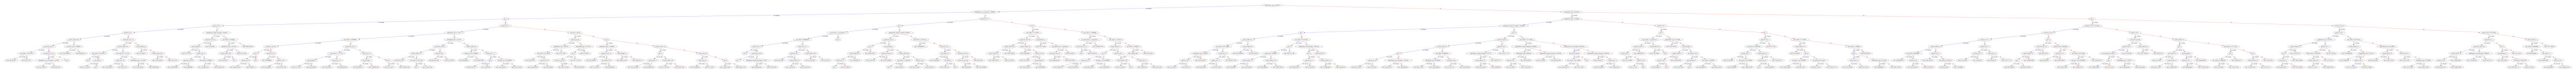

In [ ]:
# ploteamos el  o los arboles

plt.rcParams['figure.figsize'] = [80, 40]
xgb.plot_tree(xg_reg,num_trees=1)

In [ ]:
xgb.to_graphviz(xg_reg,num_trees=1)

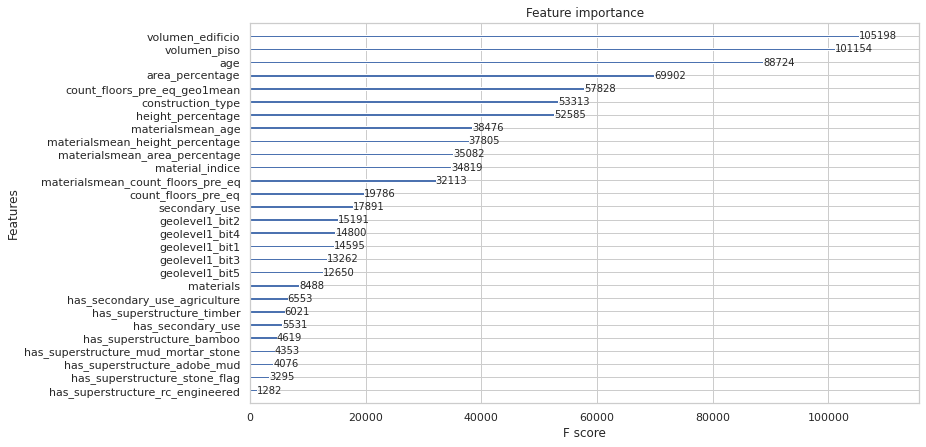

In [ ]:
# ploteamos la importancia de los features

plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [ ]:
# hacemos una prediccion para train y test

ytrain_pred = xg_reg.predict(data_train_dmatrix)
ytest_pred = xg_reg.predict(data_test_dmatrix)
ytest_pred

array([2., 2., 2., ..., 3., 3., 3.], dtype=float32)

In [ ]:
# revisamos el score para train y test
# score train: 0.738503529956406 | score test: 0.7192677892868853 da submission 0.6502
# score train: 0.8059543558174013 | score test: 0.7289362687104574 
# score train: 0.8043753343483807 | score test: 0.739394781105813 (28-07-2021 13:00) 


score_train=f1_score(y_train,ytrain_pred,average='micro')
score_test=f1_score(y_test, ytest_pred, average='micro')
print('score train: '+str(score_train)+' | score test: '+str(score_test))

score train: 0.7604799197561823 | score test: 0.683872660216348


In [ ]:
cmxgb = confusion_matrix(y_test, ytest_pred)
print(cmxgb)

[[ 5038  7346   214]
 [ 2744 60294 10570]
 [  256 19842 23302]]


In [ ]:
# hacemos una prediccion con el subset de test para submission,
# filtrado por algunas_features_seleccionadas anteriormente
# para esto primero creamos el set en formato DMATRIX sin los labels

data_submission_dmatrix = xgb.DMatrix(data=earthquakes_ampliado_test_subset)

predictions_submission = xg_reg.predict(data_submission_dmatrix)


In [ ]:
# lo transformamos a dataframe para descargarlo
# utilizando como modelo el submission_format

my_submission_xgboost = pd.DataFrame(data=predictions_submission,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission_xgboost = my_submission_xgboost.astype({'damage_grade': 'int64'})
my_submission_xgboost

,damage_grade
building_id,
300051,2
99355,2
890251,2
745817,1
421793,2
...,...
310028,2
663567,2
1049160,2


In [ ]:
my_submission_xgboost.head()

,damage_grade
building_id,
300051,2
99355,2
890251,2
745817,1
421793,2


In [ ]:
#generamos un csv para descarga
my_submission_xgboost.to_csv('submission_xgb.csv')

In [ ]:
!head submission_xgb.csv

building_id,damage_grade
300051,2
99355,2
890251,2
745817,1
421793,2
871976,2
691228,1
896100,2
343471,2


In [ ]:
files.download('submission_xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# probamos si podemos incluir un gridsearch al modelo para ajustar los hiperparametros
#parametros = {"booster":"gbtree", "objective": "multi:softmax", "num_class":4,"eta":0.02,"max_depth":12,"tree_method":"hist"}
params = {
        #'gamma': [0.1, 0.25, 0.5, 1, 2],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,9,11],
        'n_estimators': [75,100,150,300],
        'subsample': [0.4, 0.5, 0.7],
        'alpha':[0.1,0.3,0.5,0.7],
        'lambda':[1.0,1.2,1.5,1.7],
        'eta':[0.05,0.1,0.2]

        }
        #


xgb1 = XGBRegressor(eta=0.02, booster="gbtree")
folds = 4
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb1, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001)
random_search.fit(x_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 16.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed: 16.5min finished


[16:55:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f65eb8d9f50>,
                   error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, eta=0.02, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthr...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=4,
                   param_distributions={'alpha': [0.1, 0.3,

In [ ]:
print(random_search.cv_results_)

{'mean_fit_time': array([ 56.92271823, 412.56967527, 305.95238221, 104.68046999,
        87.15949184]), 'std_fit_time': array([0.24453448, 1.06696716, 0.91487081, 0.52816209, 0.99301662]), 'mean_score_time': array([ 0.55671763, 10.96698189,  5.29282659,  1.01051342,  0.67160469]), 'std_score_time': array([0.02280717, 0.07413971, 0.12843535, 0.08849736, 0.15062292]), 'param_subsample': masked_array(data=[0.5, 0.5, 0.7, 0.5, 0.7],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[75, 300, 300, 100, 150],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[7, 11, 9, 9, 6],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_lambda': masked_array(data=[1.2, 1.2, 1.0, 1.2, 1.5],
             mask=[False, False, False, False, False],
       fill_val

In [ ]:
print(random_search.best_estimator_)

XGBRegressor(alpha=0.7, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', lambda=1.5, learning_rate=0.1,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)


In [ ]:
print(random_search.best_params_)

{'subsample': 0.7, 'n_estimators': 150, 'max_depth': 6, 'lambda': 1.5, 'eta': 0.1, 'alpha': 0.7}


In [ ]:
# probamos si se puede con clasificacion y grid search cv

xgb2 = XGBClassifier(eta=0.02, booster="gbtree")
folds = 4
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid_search = GridSearchCV(xgb2 ,param_grid=params, n_jobs=4, cv=skf.split(x_train,y_train), verbose=0)
grid_search.fit(x_train, y_train)

# RED NEURONAL

**EN EL SIGUIENTE APARTADO PROBAMOS REDES NEURONALES, INCORPORANDO RATIOS Y CATEGORIAS ENCONTRADAS RELEVANTES EN ANALISIS EXPLORATORIO**

In [ ]:
# las categorias a seleccionarse son:
# foundation_type_i
# foundation_type_u
# ground_floor_type_v
# ground_floor_type_x (menor medida)
# other_floor_type_s
# plan_configuration_u
# roof_type_x

# los ratios serán el mean de age, height y area por cada geo_level_2_id

In [ ]:
#AHORA PROBAMOS CON TENSORFLOW y KERAS

import tensorflow as tf
import tensorflow.keras as kr

In [ ]:
#UTILIZANDO CODIGO DE TUTORIAL EN YOUTUBE (DOTCSV)
# (https://youtu.be/qTNUbPkR2ao?t=765)

# armamos un subset de prueba para keras
features_select_keras = [#'foundation_type',
                         #'ground_floor_type',
                         #'other_floor_type',
                         #'plan_configuration',
                         #'roof_type',
                         'age',
                         'ratio_edificio',
                         'area_percentage',
                         'height_percentage',
                         'count_floors_pre_eq',
                         'material_indice',
                         'materials',
                         'materialsmean_age',
                         'materialsmean_area_percentage',
                         'materialsmean_height_percentage',
                         'materialsmean_count_floors_pre_eq',

                         'secondary_use',
                         'construction_type',
                         'count_floors_pre_eq_geo1mean'
                         'count_floors_pre_eq_geo2mean',
                         'age_geo2mean',
                         'ratio_edificio_geo3',
                         #'area_percentage_geo3mean',
                         #'height_percentage_geo3mean',
                         #'geolevel1_bit1',
                         #'geolevel1_bit2',
                         #'geolevel1_bit3',
                         #'geolevel1_bit4',
                         #'geolevel1_bit5',
                         ]

# el mismo lo colocaremos en el dataframe earthquakes_subset_keras y con getdummies pasaremos todos los categoricos a bits de categorias
earthquakes_subset_keras = earthquakes_ampliado[features_seleccionadas]#features_select_keras
earthquakes_subset_keras = pd.get_dummies(earthquakes_subset_keras)

# luego nos quedamos con un subset llamado earthquakes_ampliado_keras, eligiendo entre campos y categorias
algunas_features_select_keras = [
                          'age',
                         'ratio_edificio',
                         'area_percentage',
                         'height_percentage',
                         'count_floors_pre_eq',
                         'material_indice',
                         'materials',
                         'materialsmean_age',
                         'materialsmean_area_percentage',
                         'materialsmean_height_percentage',
                         'materialsmean_count_floors_pre_eq',

                         'secondary_use',
                         'construction_type',
                         'count_floors_pre_eq_geo1mean'
                         'count_floors_pre_eq_geo2mean',
                         'age_geo2mean',
                         'ratio_edificio_geo3',
                         #'area_percentage_geo3mean',
                         #'height_percentage_geo3mean',
                         #'geolevel1_bit1',
                         #'geolevel1_bit2',
                         #'geolevel1_bit3',
                         #'geolevel1_bit4',
                         #'geolevel1_bit5',
                         ]

earthquakes_ampliado_keras=earthquakes_subset_keras[algunas_features_seleccionadas]
earthquakes_ampliado_keras

,count_floors_pre_eq_geo1mean,ratio_edificio,area_percentage,height_percentage,count_floors_pre_eq,age,materials,secondary_use,construction_type,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,material_indice,count_floors_pre_eq_geo2mean
building_id,,,,,,,,,,,,,,,
802906,2.22,0.83,6,5,2,30,0.58,0.89,0.00,28.01,7.92,5.84,2.33,0.26,1.95
28830,2.21,0.88,8,7,2,10,0.58,0.89,0.00,21.51,7.46,5.32,2.12,0.26,2.17
94947,2.53,1.00,5,5,2,10,0.58,0.89,0.00,21.51,7.46,5.32,2.12,0.26,2.71
590882,1.85,0.83,6,5,2,10,0.25,0.89,0.00,19.96,7.54,5.21,2.05,0.25,1.55
201944,2.55,1.12,8,9,3,30,0.17,0.89,0.00,34.52,8.38,6.35,2.54,0.26,2.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1.80,0.50,6,3,1,55,0.58,0.89,2.00,21.51,7.46,5.32,2.12,0.26,1.00
669485,2.32,0.83,6,5,2,0,0.58,0.89,0.00,21.51,7.46,5.32,2.12,0.26,2.67
602512,2.32,1.17,6,7,3,55,0.58,0.89,0.00,21.51,7.46,5.32,2.12,0.26,2.77


In [ ]:
#normalizamos el dataset

norm_earthquakes_ampliado_keras=(earthquakes_ampliado_keras-earthquakes_ampliado_keras.mean())/earthquakes_ampliado_keras.std()
norm_earthquakes_ampliado_keras

,count_floors_pre_eq_geo1mean,ratio_edificio,area_percentage,height_percentage,count_floors_pre_eq,age,materials,secondary_use,construction_type,materialsmean_age,materialsmean_area_percentage,materialsmean_height_percentage,materialsmean_count_floors_pre_eq,material_indice,count_floors_pre_eq_geo2mean
building_id,,,,,,,,,,,,,,,
802906,0.30,0.04,-0.46,-0.23,-0.18,0.44,0.85,0.35,-0.34,1.16,-0.10,0.83,1.09,0.50,-0.40
28830,0.27,0.12,-0.00,0.82,-0.18,-0.58,0.85,0.35,-0.34,-0.06,-0.44,-0.38,-0.17,0.40,0.09
94947,1.28,0.36,-0.69,-0.23,-0.18,-0.58,0.85,0.35,-0.34,-0.06,-0.44,-0.38,-0.17,0.40,1.31
590882,-0.90,0.04,-0.46,-0.23,-0.18,-0.58,-0.98,0.35,-0.34,-0.35,-0.38,-0.65,-0.61,0.25,-1.32
201944,1.34,0.61,-0.00,1.86,1.20,0.44,-1.42,0.35,-0.34,2.38,0.23,2.05,2.36,0.40,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,-1.07,-0.62,-0.46,-1.27,-1.55,1.72,0.85,0.35,-0.27,-0.06,-0.44,-0.38,-0.17,0.40,-2.56
669485,0.60,0.04,-0.46,-0.23,-0.18,-1.09,0.85,0.35,-0.34,-0.06,-0.44,-0.38,-0.17,0.40,1.22
602512,0.60,0.69,-0.46,0.82,1.20,1.72,0.85,0.35,-0.34,-0.06,-0.44,-0.38,-0.17,0.40,1.45


In [ ]:
# dividimos en train y test para X(datos) e Y(labels)

x_train,x_test,y_train,y_test=train_test_split(norm_earthquakes_ampliado_keras,earthquakes_labels,test_size=0.85,random_state=123)
num_x_train= x_train.shape[0]
num_x_test=x_test.shape[0]
print('train:' + str(num_x_train) + ' test:' + str(num_x_test))

train:38881 test:220330


In [ ]:
# Creamos el objeto que contendrá a nuestra red neuronal, como
# secuencia de capas ("Sequential").
model = kr.Sequential()

# Añadimos la capa 1
# se la denomina Dense por ser fully connected
# (o sea se conectaran todas con todas a la siguiente capa)
# y con tipo de activacion relu
# input_shape corresponde a los datos de entrada

l1 = model.add(kr.layers.Dense(15, activation='relu'))#,input_shape=(23,)

# Añadimos la capa 2 tipo Dense con activacion relu
l2 = model.add(kr.layers.Dense(60, activation='relu'))

# Añadimos la capa 3 tipo Dense con activacion relu
l3 = model.add(kr.layers.Dense(30, activation='relu'))

# Añadimos la capa 4 tipo Dense con activacion relu
#l4 = model.add(kr.layers.Dense(15, activation='relu'))

# Añadimos la ultima capa tipo Dense (vienen conexiones de todas las neuronas anteriores)
# de tipo de activación softmax porque es la última capa para devolver las probabilidades
# para cada valor de label (damage_grade) donde se incluye el cero por lo que son 4 neuronas (¿¿¿???)

l5 = model.add(kr.layers.Dense(4, activation='softmax'))

# Compilamos el modelo, definiendo la función de coste y el optimizador.
# en este caso a diferencia del tutorial, utilizamos otra función de coste
model.compile(loss='sparse_categorical_crossentropy', optimizer=kr.optimizers.SGD(lr=0.02), metrics=['accuracy'])

In [ ]:
# entrenamos al modelo con 150 iteraciones.

historial_keras=model.fit(x_train, y_train, epochs=2500)
print("modelo en keras entrenado")

Se han truncado las últimas 5000 líneas del flujo de salida.
1216/1216 [==============================] - 2s 1ms/step - loss: 0.8166 - accuracy: 0.6053
Epoch 2/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7678 - accuracy: 0.6265
Epoch 3/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7619 - accuracy: 0.6330
Epoch 4/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7573 - accuracy: 0.6377
Epoch 5/2500
1216/1216 [==============================] - 2s 2ms/step - loss: 0.7537 - accuracy: 0.6394
Epoch 6/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7502 - accuracy: 0.6405
Epoch 7/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7464 - accuracy: 0.6440
Epoch 8/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7437 - accuracy: 0.6456
Epoch 9/2500
1216/1216 [==============================] - 2s 1ms/step - loss: 0.7416 - accuracy: 0.6457
Epoch 10/2500
12

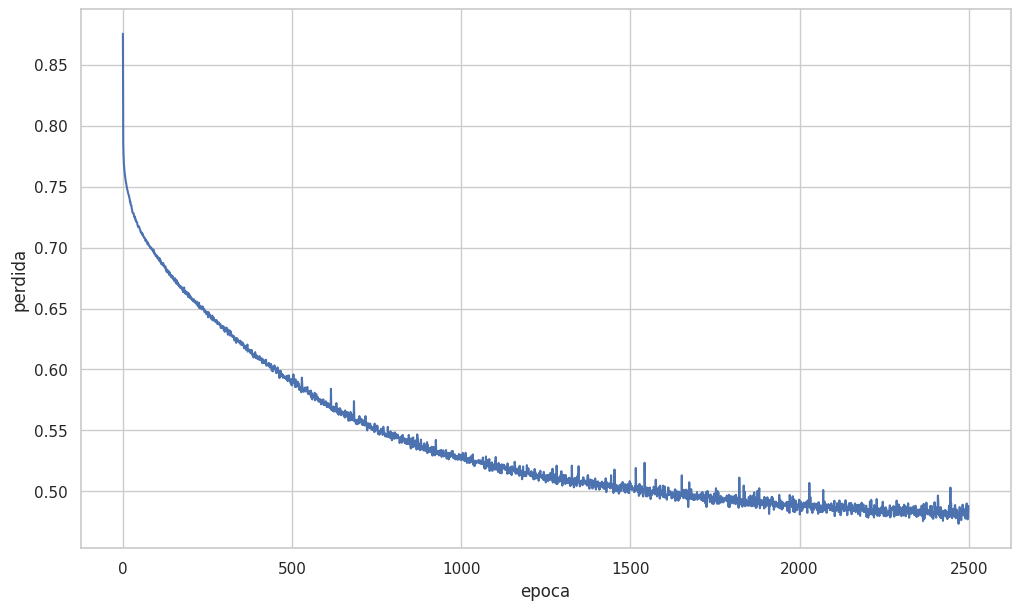

In [ ]:
# con un plot de "loss vs epoca" podemos ver el progreso del entrenamiento
plt.xlabel("epoca")
plt.ylabel("perdida")
plt.plot(historial_keras.history["loss"])

In [ ]:
# con una funcion argmax de numpy, convertimos el array de resultados de probabilidad de
# cada neurona de salida (grados de damage) en un solo valor (0,1,2 o 3)
# tras hacer una prediccion en train y test
# luego medimos score f1 para ver el resultado del modelo

serie_prediccion_train=np.argmax(model.predict(x_train[algunas_features_seleccionadas]),axis=-1)
serie_prediccion_test=np.argmax(model.predict(x_test[algunas_features_seleccionadas]),axis=-1)
train_score=f1_score(y_train, serie_prediccion_train, average='micro')
test_score=f1_score(y_test, serie_prediccion_test, average='micro')

print('score train: '+str(train_score)+' | score test: '+ str(test_score))
# mejor score (train 0.76470 test 0.65607 submission 0.6441)

score train: 0.7957561728395062 | score test: 0.5947508842603685


In [ ]:
# hacemos una prediccion para los datos de test destinados a submission

earthquakes_subset_keras_test = earthquakes_ampliado_test[features_select_keras]
earthquakes_subset_keras_test = pd.get_dummies(earthquakes_subset_keras_test)
serie_prediccion_submission=np.argmax(model.predict(earthquakes_subset_keras_test[algunas_features_seleccionadas]),axis=-1)

In [ ]:
#lo transformamos a dataframe para descargarlo
my_submission_redneuronal = pd.DataFrame(data=serie_prediccion_submission,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission_redneuronal.head()

,damage_grade
building_id,
300051,3
99355,3
890251,3
745817,3
421793,3


In [ ]:
#generamos un csv para descarga
my_submission_redneuronal.to_csv('submission_redneuronal.csv')

In [ ]:
!head submission_redneuronal.csv

building_id,damage_grade
300051,3
99355,3
890251,3
745817,3
421793,3
871976,2
691228,3
896100,2
343471,2


In [ ]:
files.download('submission_redneuronal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>